In [75]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os

from PIL import *
import cv2

import time
import math

import torch
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from tqdm.cli import tqdm as tq

from statistics import mean
from typing import Tuple, Dict, Iterable

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload

In [4]:
autoreload 2

In [5]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 300

In [6]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [7]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# MaskRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be ['0']. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=14,
                                                     sampling_ratio=2)
# put the pieces together inside a MaskRCNN model
model = MaskRCNN(backbone,
                 num_classes=2,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler)
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

/Users/personal/Documents/Topics/Model training/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/personal/Documents/Topics/Model training/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model = maskrcnn_resnet50_fpn(
    pretrained = True,
)

# Change number of output classes to two ( no-crater, crater )
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = FastRCNNPredictor( in_features, num_classes = 2 )

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = ( param_size + buffer_size ) / 1024 ** 2
print('model size: {:.3f}MB'.format(size_all_mb))

/Users/personal/Documents/Topics/Model training/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model size: 168.043MB


In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [28]:
from exterres_dataset_mask import load_bounding_boxes, load_projected_ellipses, compute_mask

In [162]:
boxes = load_bounding_boxes( ['A2_ACW_frame300.png'] )

ellipses = load_projected_ellipses( 'A2_ACW_frame300.png' )

masks = compute_mask( ( 1200, 1920 ), ellipses['ellipse_sparse'] )

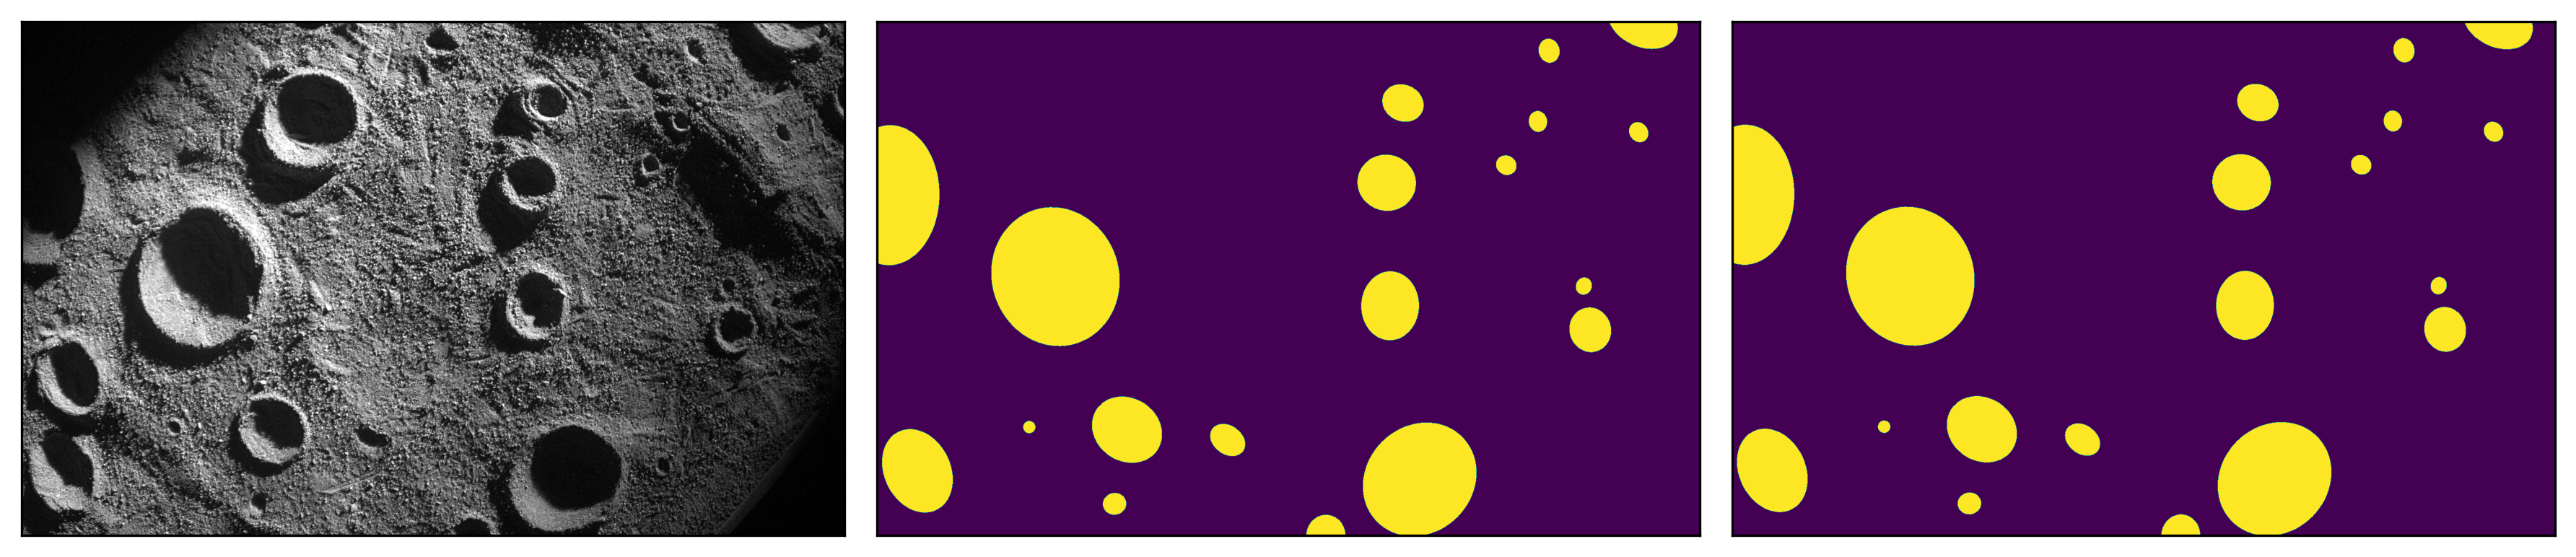

In [163]:
fig, ax = plt.subplots( ncols = 3 )

img = Image.open('Craters/A2_ACW_frame300.png')
ax[0].imshow(img)

# Second image is masks
img = np.zeros( ( 1200, 1920 ) )
for im in masks:
    img = img + im.numpy()
ax[1].imshow( img )

# Next show contours
ellipses = []
for im in masks:
    im = im.numpy()
    threshold = 0.5
    canny_output = cv2.Canny( cv2.merge( ( im, im, im ) ), threshold, threshold * 2 )
    contours, _ = cv2.findContours( canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE ) 
    
    for contour in contours:
        # Hopefully only ever one!
        if contour.shape[0] > 5:
            ellipses.append( cv2.fitEllipse( contour ) )

img = np.zeros( ( 1200, 1920 ) )
for ellipse in ellipses:
    cv2.ellipse(
        img,
        ( int( ellipse[0][0] ), int( ellipse[0][1] ) ),
        ( int( ellipse[1][0] / 2 ), int( ellipse[1][1] / 2 ) ),
        ellipse[2],
        0, # Start Angle for drawing
        360, # End Angle for drawing
        ( 1 ),
        -1, # Mask should be filled
    )
ax[2].imshow( img )

for i in range( 3 ):
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )

fig.tight_layout()
plt.show()


In [80]:
# Create a list to hold the names of PNG files
craters = []

# Iterate through each file in the directory
for filename in os.listdir('Craters') :
    craters.append(filename)

In [119]:
# Build CDA database (typically takes about a minute)
from exterres_dataset_mask import CraterDataset

cd = CraterDataset( craters, ( 1200, 1920 ) )

Filter bad samples:
Total Images after Filtering 378


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.890196].


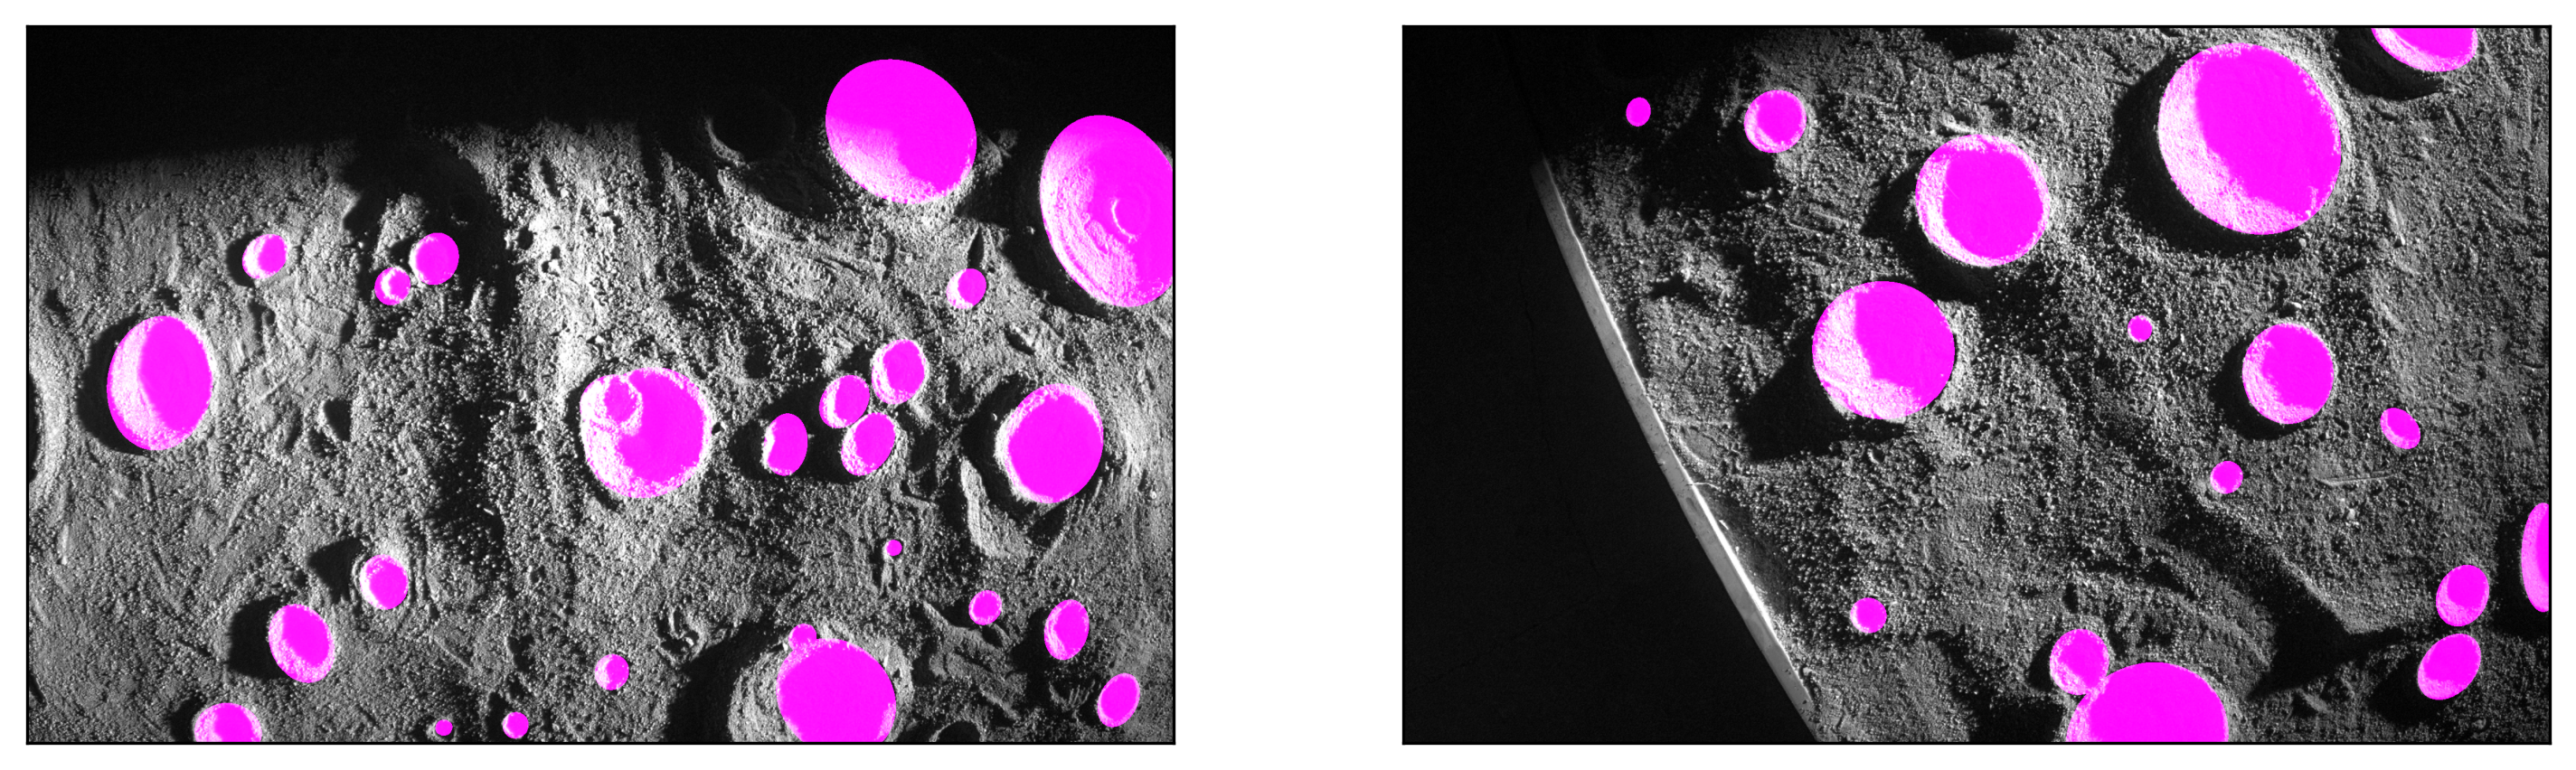

In [175]:
# Show a random sample of images
n_samples = 2
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    img, target = cd.__getitem__( int( np.random.rand() * cd.__len__() ) )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )

    for mask in target['masks']:
        img[:,:,0] += mask.numpy()
        img[:,:,2] += mask.numpy()

    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()

In [164]:
# Return the batch as an iterable, skipping 'None' samples
def collate_fn(batch: Iterable):
    return tuple( zip( *( filter( lambda x:x is not None, batch ) ) ) )

In [170]:
# Split the dataset into train and test
trainIndices, testIndices = cd.testSplit()
print( 'Training samples:', len( trainIndices ) )
print( 'Testing samples:', len( testIndices ) )

dataset_train = torch.utils.data.Subset( cd, trainIndices )
dataset_test = torch.utils.data.Subset( cd, testIndices )

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 4,
    shuffle = True,
    num_workers = 16,
    collate_fn = collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size = 8,
    shuffle = False,
    num_workers = 16,
    collate_fn = collate_fn
)

Training samples: 336
Testing samples: 42


In [171]:
initial_lr = 1e-2
momentum = 0.9
weight_decay = 0.0005

model.to( device )
params = [ p for p in model.parameters() if p.requires_grad ]
optimizer = SGD( params, lr = initial_lr, momentum = momentum, weight_decay = weight_decay )
scheduler = ReduceLROnPlateau( optimizer, patience = 5, cooldown = 2 )
# Early stopping????

In [173]:
# Make metrics dict with the required keys
def init_run_metrics():
    return dict(
        train = dict(
            batch = list(),
            loss_total = list(),
            loss_classifier = list(),
            loss_box_reg = list(),
            loss_objectness = list(),
            loss_rpn_box_reg = list(),
            loss_mask = list(),
        ),
        valid = dict(
            batch = list(),
            loss_total = list(),
            loss_classifier = list(),
            loss_box_reg = list(),
            loss_objectness = list(),
            loss_rpn_box_reg = list(),
            loss_mask = list(),
        ),
    )

In [174]:
model.train()

for img, target in data_loader:
    img = list( image.to( device ) for image in img )
    target = [{k: v.to(device) for k, v in t.items()} for t in target]
    out = model( img, target )
    break

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'collate_fn' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line

RuntimeError: DataLoader worker (pid(s) 69968) exited unexpectedly

In [21]:
out

{'loss_classifier': tensor(0.8830, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.6348, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_mask': tensor(0.4826, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(7.5746, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.2544, device='cuda:0', grad_fn=<DivBackward0>)}

In [19]:
model_name = 'mask_rcnn'

start_e = 1
EPOCHS = 50

run_metrics = init_run_metrics()

for e in range(start_e, EPOCHS + start_e):
    train_loader, validation_loader, test_loader = ( data_loader, data_loader_test, data_loader_test )

    print(f'\n-----Epoch {e} started-----\n')

    since = time.time()

    model.train()
    bar = tq( train_loader, desc = f"Training [{e}]",
                postfix = {
                    "loss_total": 0.,
                    "loss_classifier": 0.,
                    "loss_box_reg": 0.,
                    "loss_ellipse": 0.,
                    "loss_objectness": 0.,
                    "loss_rpn_box_reg": 0.,
                } )
    
    for batch, ( images, targets ) in enumerate( bar, 1 ):
        images = list( image.to( device ) for image in images )
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model( images, targets )
        loss = sum( l for l in loss_dict.values() )

        if not math.isfinite(loss):
            del images, targets
            raise RuntimeError(f"Loss is {loss}, stopping training")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        postfix = dict( loss_total = loss.item() )
        run_metrics["train"]["loss_total"].append( loss.item() )
        run_metrics["train"]["batch"].append( batch )

        for k, v in loss_dict.items():
            postfix[k] = v.item()
            run_metrics["train"][k].append( v.item() )

        bar.set_postfix(ordered_dict=postfix)

    with torch.no_grad():
        bar = tq(validation_loader, desc=f"Validation [{e}]",
                    postfix={
                        "loss_total": 0.,
                        "loss_classifier": 0.,
                        "loss_box_reg": 0.,
                        "loss_ellipse": 0.,
                        "loss_objectness": 0.,
                        "loss_rpn_box_reg": 0
                    })
        for batch, (images, targets) in enumerate(bar, 1):
            images = list( image.to( device ) for image in images )
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model( images, targets )
            loss = sum(l for l in loss_dict.values())

            if not math.isfinite(loss):
                del images, targets
                raise RuntimeError(f"Loss is {loss}, stopping validation")

            postfix = dict(loss_total=loss.item())
            run_metrics["valid"]["loss_total"].append(loss.item())
            run_metrics["valid"]["batch"].append(batch)

            for k, v in loss_dict.items():
                postfix[k] = v.item()
                run_metrics["valid"][k].append(v.item())

            bar.set_postfix(ordered_dict=postfix)

    time_elapsed = time.time() - since

    scheduler.step( mean( run_metrics["valid"]["loss_total"][(e - 1) * len(validation_loader):e * len(validation_loader)] ) )

    state_dict = {
        'epoch': e,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'run_metrics': run_metrics,
    }

    images, targets = next(iter(test_loader))
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    print(
        f"\nSummary:\n",
        f"\tEpoch: {e}/{EPOCHS + start_e - 1}\n",
        f"\tAverage train loss: {mean(run_metrics['train']['loss_total'][(e - 1) * len(train_loader):e * len(train_loader)])}\n",
        f"\tAverage validation loss: {mean(run_metrics['valid']['loss_total'][(e - 1) * len(validation_loader):e * len(validation_loader)])}\n",
        f"\tDuration: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
    )
    
    joblib.dump( run_metrics, 'training_metrics/' + model_name )

    if e % 1 == 0:
        torch.save( model.state_dict(), 'training_checkpoints/' + model_name + '_' + str( e ) + '.blob' )
        print(f'Saved Model Checkpoint\n')
    print(f'-----Epoch {e} finished.-----\n')


-----Epoch 1 started-----



Validation [1]: 100%|██████████| 84/84 [01:28<00:00,  1.05s/it, loss_total=0.929, loss_classifier=0.173, loss_box_reg=0.241, loss_mask=0.176, loss_objectness=0.154, loss_rpn_box_reg=0.186]  



Summary:
 	Epoch: 1/50
 	Average train loss: 1.0779797284895745
 	Average validation loss: 0.9562874415091106
 	Duration: 10m 11s
Saved Model Checkpoint

-----Epoch 1 finished.-----


-----Epoch 2 started-----



Validation [2]: 100%|██████████| 84/84 [01:29<00:00,  1.07s/it, loss_total=0.876, loss_classifier=0.24, loss_box_reg=0.24, loss_mask=0.16, loss_objectness=0.133, loss_rpn_box_reg=0.104]     



Summary:
 	Epoch: 2/50
 	Average train loss: 0.8580808122632969
 	Average validation loss: 0.9009692037389392
 	Duration: 10m 22s
Saved Model Checkpoint

-----Epoch 2 finished.-----


-----Epoch 3 started-----



Validation [3]: 100%|██████████| 84/84 [01:28<00:00,  1.06s/it, loss_total=1.01, loss_classifier=0.207, loss_box_reg=0.212, loss_mask=0.15, loss_objectness=0.313, loss_rpn_box_reg=0.124]    



Summary:
 	Epoch: 3/50
 	Average train loss: 0.762121661328214
 	Average validation loss: 0.8303783933321635
 	Duration: 10m 10s
Saved Model Checkpoint

-----Epoch 3 finished.-----


-----Epoch 4 started-----



Validation [4]: 100%|██████████| 84/84 [01:28<00:00,  1.06s/it, loss_total=1.05, loss_classifier=0.329, loss_box_reg=0.215, loss_mask=0.148, loss_objectness=0.261, loss_rpn_box_reg=0.0953]  



Summary:
 	Epoch: 4/50
 	Average train loss: 0.6934002275677994
 	Average validation loss: 0.8204613285405296
 	Duration: 10m 15s
Saved Model Checkpoint

-----Epoch 4 finished.-----


-----Epoch 5 started-----



Validation [5]: 100%|██████████| 84/84 [01:31<00:00,  1.09s/it, loss_total=0.712, loss_classifier=0.171, loss_box_reg=0.191, loss_mask=0.128, loss_objectness=0.124, loss_rpn_box_reg=0.0977] 



Summary:
 	Epoch: 5/50
 	Average train loss: 0.6432168056187735
 	Average validation loss: 0.7846484560342062
 	Duration: 10m 22s
Saved Model Checkpoint

-----Epoch 5 finished.-----


-----Epoch 6 started-----



Validation [6]: 100%|██████████| 84/84 [01:28<00:00,  1.06s/it, loss_total=1.12, loss_classifier=0.28, loss_box_reg=0.207, loss_mask=0.199, loss_objectness=0.325, loss_rpn_box_reg=0.111]    



Summary:
 	Epoch: 6/50
 	Average train loss: 0.602678834372603
 	Average validation loss: 0.7958054659622056
 	Duration: 10m 13s
Saved Model Checkpoint

-----Epoch 6 finished.-----


-----Epoch 7 started-----



Validation [7]: 100%|██████████| 84/84 [01:30<00:00,  1.08s/it, loss_total=1, loss_classifier=0.265, loss_box_reg=0.225, loss_mask=0.2, loss_objectness=0.22, loss_rpn_box_reg=0.0889]        



Summary:
 	Epoch: 7/50
 	Average train loss: 0.5659290850162506
 	Average validation loss: 0.7829447757630121
 	Duration: 10m 14s
Saved Model Checkpoint

-----Epoch 7 finished.-----


-----Epoch 8 started-----



Validation [8]: 100%|██████████| 84/84 [01:28<00:00,  1.06s/it, loss_total=1.26, loss_classifier=0.354, loss_box_reg=0.265, loss_mask=0.188, loss_objectness=0.331, loss_rpn_box_reg=0.126]   



Summary:
 	Epoch: 8/50
 	Average train loss: 0.5302623194348165
 	Average validation loss: 0.7973764506833894
 	Duration: 10m 15s
Saved Model Checkpoint

-----Epoch 8 finished.-----


-----Epoch 9 started-----



Training [9]:  68%|██████▊   | 339/497 [06:06<02:45,  1.05s/it, loss_total=0.519, loss_classifier=0.105, loss_box_reg=0.169, loss_mask=0.157, loss_objectness=0.0466, loss_rpn_box_reg=0.0422]   IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [20]:
run_metrics = joblib.load( './training_metrics/mask_rcnn' )

/home/mjr/.conda/envs/detectron2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mjr/.conda/envs/detectron2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


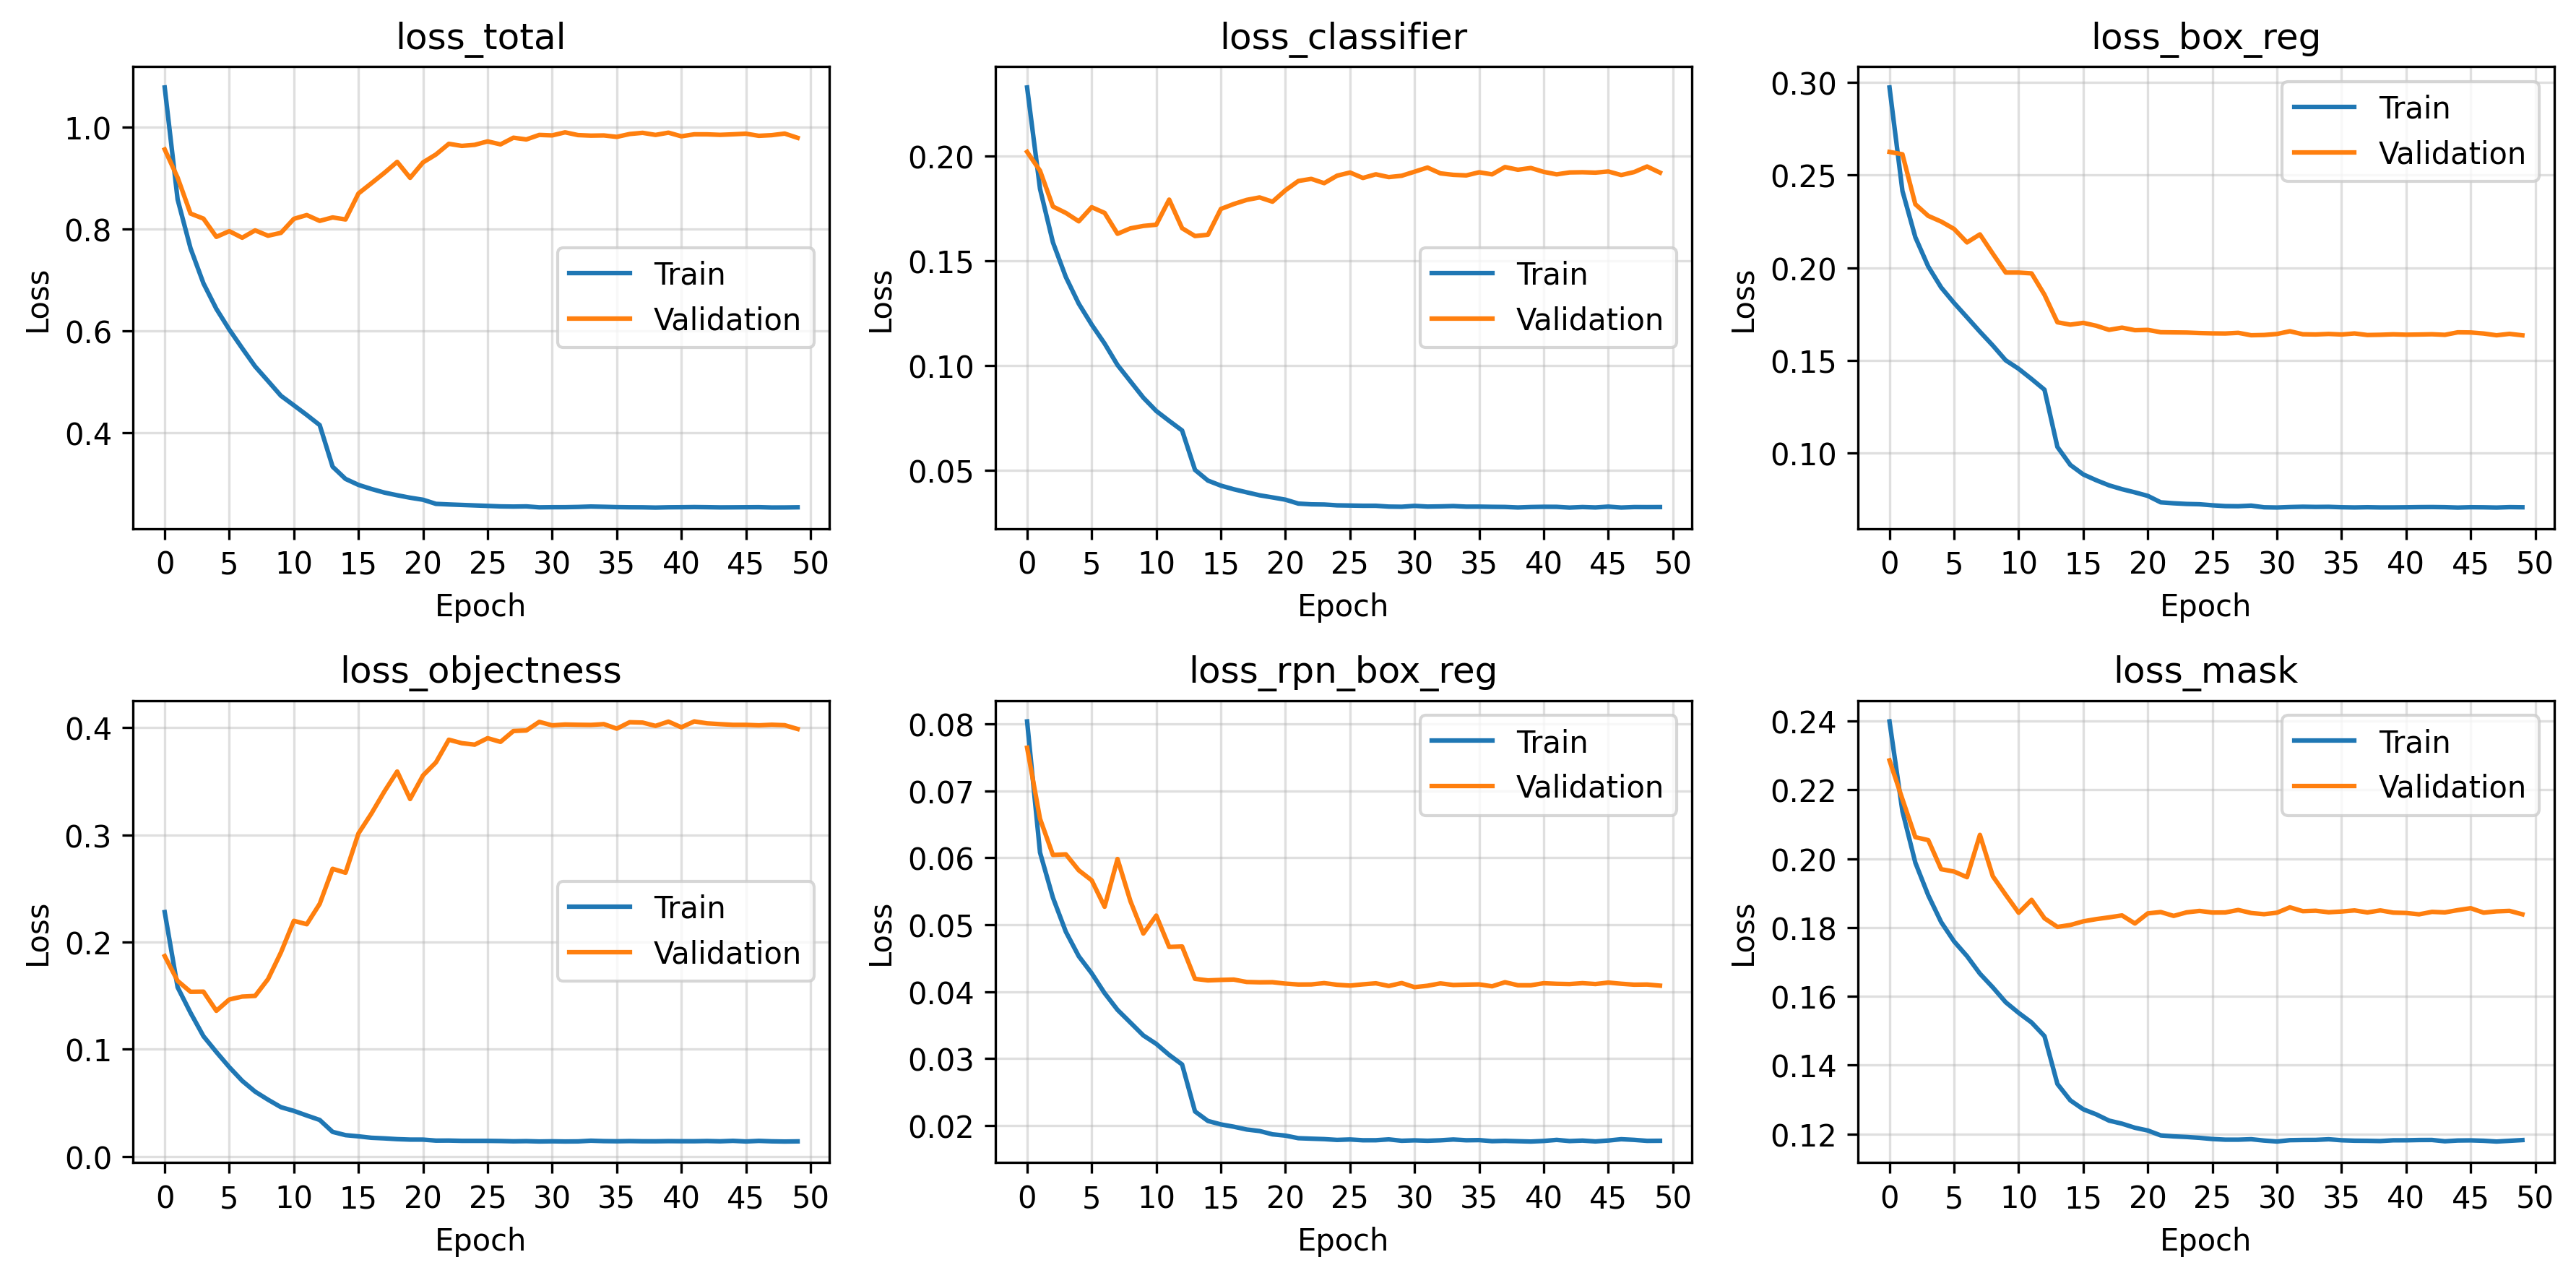

In [21]:
epoch_losses_combined = []

for s in [ 'train', 'valid' ]:
    epoch_losses = {}
    n_batches = np.max( run_metrics[s]['batch'] )
    keys = list( run_metrics[s].keys() )[1:] # Skip the batch number

    # Collect average losses per key per epoch
    for key in keys:
        l = []
        for i in range( len( run_metrics[s][key] ) ):
            l.append( np.mean( run_metrics[s][key][i * n_batches:( i + 1 ) * n_batches] ) )
        epoch_losses[key] = l
    epoch_losses_combined.append( epoch_losses )

# Plot average loss per epoch
fig, ax = plt.subplots( ncols = 3, nrows = 2 )
for i, row in enumerate( ax ):
    for j, col in enumerate( row ):
        col.plot( epoch_losses_combined[0][keys[i*3 + j]] ) # Train Loss
        col.plot( epoch_losses_combined[1][keys[i*3 + j]] ) # Validation Loss
        col.legend( [ 'Train', 'Validation' ] )
        col.set_title( keys[i*3 + j] )
        col.grid( alpha = 0.4 )
        col.set_xlabel( 'Epoch' )
        col.set_ylabel( 'Loss' )
        col.set_xticks( np.arange( 0, EPOCHS + 1, 5 ) )
fig.tight_layout()
plt.show()

In [22]:
np.argsort( epoch_losses_combined[1]['loss_total'] )

array([   6,    4,    8, ..., 1440, 1410, 4199])

In [17]:
path = "training_checkpoints/mask_rcnn_6.blob"
model.load_state_dict( torch.load( path ) )
model.eval()
model.to( device )
print( 'Loaded:', path )

Loaded: training_checkpoints/mask_rcnn_6.blob


In [18]:
model.eval()

predictions = []

with torch.no_grad():
    bar = tq( data_loader_test )
    for batch, ( images, targets ) in enumerate( bar, 1 ):
        images = list( image.to( device ) for image in images )
        targets = [ { k: v.to( device ) for k, v in t.items() } for t in targets ]
        preds = model( images )

        # Preds is a list of dicts
        for p in preds:
            for item in p.values():
                print( item )
                item.to( 'cpu' ) # Put each output onto the cpu
        predictions.extend( preds )

  0%|          | 0/84 [00:00<?, ?it/s]

tensor([[4.8632e+02, 4.8608e+02, 5.3779e+02, 5.3657e+02],
        [1.6976e+01, 2.3325e+02, 7.7312e+01, 2.9826e+02],
        [6.9019e+02, 3.4142e+02, 7.5010e+02, 4.0337e+02],
        [1.5334e+02, 7.3899e+02, 1.9264e+02, 7.7764e+02],
        [7.5013e+02, 1.4174e+02, 8.3965e+02, 2.3061e+02],
        [3.2673e+02, 2.3831e+02, 3.8049e+02, 2.9382e+02],
        [2.5854e+02, 2.4666e+00, 3.2411e+02, 5.6933e+01],
        [2.5356e+02, 2.5133e+02, 2.9755e+02, 2.9391e+02],
        [4.5900e+01, 2.9413e+02, 1.3440e+02, 3.7714e+02],
        [5.6888e+02, 2.9006e+02, 6.2438e+02, 3.4680e+02],
        [8.7969e+02, 4.3631e+02, 9.3251e+02, 4.8877e+02],
        [5.7080e+02, 9.9184e+02, 5.9917e+02, 1.0220e+03],
        [1.1741e+01, 7.0207e+01, 4.0974e+01, 9.8659e+01],
        [5.1554e+00, 8.2208e+02, 3.8578e+01, 8.5665e+02],
        [5.6403e+02, 3.9114e+02, 5.9371e+02, 4.2103e+02],
        [7.2505e+02, 3.8565e+02, 8.2433e+02, 4.8374e+02],
        [1.3612e+02, 6.5959e+02, 1.9707e+02, 7.1752e+02],
        [8.494

  1%|          | 1/84 [00:10<14:33, 10.53s/it]

tensor([[ 425.7906,  169.9088,  458.0547,  197.0750],
        [ 489.0595,  488.5166,  532.5168,  533.7695],
        [ 867.8781,  198.6296,  982.6086,  314.4684],
        [ 774.9301,  725.3658,  805.4691,  757.9329],
        [ 802.4646,  323.0895,  862.9257,  385.6943],
        [ 729.7735,  201.2293,  816.1448,  285.0145],
        [ 936.3195,  584.3015,  966.6042,  615.0929],
        [ 606.9523,  280.2263,  635.7769,  309.3229],
        [ 395.2073,  685.7202,  587.8973,  884.7621],
        [ 674.1714,  569.9030,  706.4348,  602.8621],
        [ 884.2696,  407.7711,  975.9371,  500.4028],
        [ 384.2701,  840.5808,  445.4047,  901.5428],
        [ 669.5707,    0.0000,  791.2798,   81.5260],
        [ 958.0239,  893.8349, 1021.3143,  954.2736],
        [ 805.3199,  216.4803,  881.6202,  301.0307],
        [ 448.1871,  671.3103,  474.3877,  695.2414],
        [ 352.0301,  573.7690,  384.3243,  605.9027],
        [ 619.6322,   60.0975,  644.8901,   83.5161],
        [ 712.6326,  517.291

  2%|▏         | 2/84 [00:14<09:08,  6.68s/it]

tensor([[491.4290, 490.4749, 531.8633, 530.9990],
        [412.9521, 316.3912, 435.9234, 339.8205],
        [484.1863,  34.3622, 505.4760,  54.0851]], device='cuda:0')
tensor([1, 1, 1], device='cuda:0')
tensor([0.9989, 0.9891, 0.4534], device='cuda:0')
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,

  4%|▎         | 3/84 [00:18<07:07,  5.28s/it]

tensor([[4.2514e+02, 5.4500e+02, 5.7773e+02, 6.8320e+02],
        [2.5217e+02, 6.1562e+02, 3.0518e+02, 6.7050e+02],
        [4.4084e+01, 4.6028e+02, 1.0406e+02, 5.2293e+02],
        [5.9457e+02, 8.5997e+01, 6.6612e+02, 1.5637e+02],
        [0.0000e+00, 5.9159e+02, 9.6429e+01, 7.1948e+02],
        [3.2394e+02, 5.0863e+02, 4.5627e+02, 6.4448e+02],
        [6.9496e+02, 1.2742e+02, 7.6803e+02, 1.9638e+02],
        [4.0540e+02, 3.9543e+02, 4.6361e+02, 4.5533e+02],
        [8.8846e+01, 9.2763e+02, 1.4101e+02, 9.8291e+02],
        [7.1296e+02, 1.0011e+02, 7.6765e+02, 1.5094e+02],
        [8.5389e+02, 9.6494e+02, 8.7977e+02, 9.9169e+02],
        [9.1272e+02, 5.0201e+02, 9.9452e+02, 5.8587e+02],
        [2.6877e+02, 3.0483e-01, 3.7057e+02, 9.0370e+01],
        [4.5660e+02, 2.2448e+02, 6.3169e+02, 4.0400e+02],
        [1.8737e+02, 3.0255e+02, 3.7408e+02, 4.7667e+02],
        [6.0017e+02, 3.8159e+02, 6.9524e+02, 4.7484e+02],
        [4.0520e+02, 1.7480e+02, 4.3527e+02, 2.0522e+02],
        [3.025

  5%|▍         | 4/84 [00:27<09:07,  6.84s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB (GPU 0; 14.58 GiB total capacity; 14.04 GiB already allocated; 99.56 MiB free; 14.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

IndexError: list index out of range

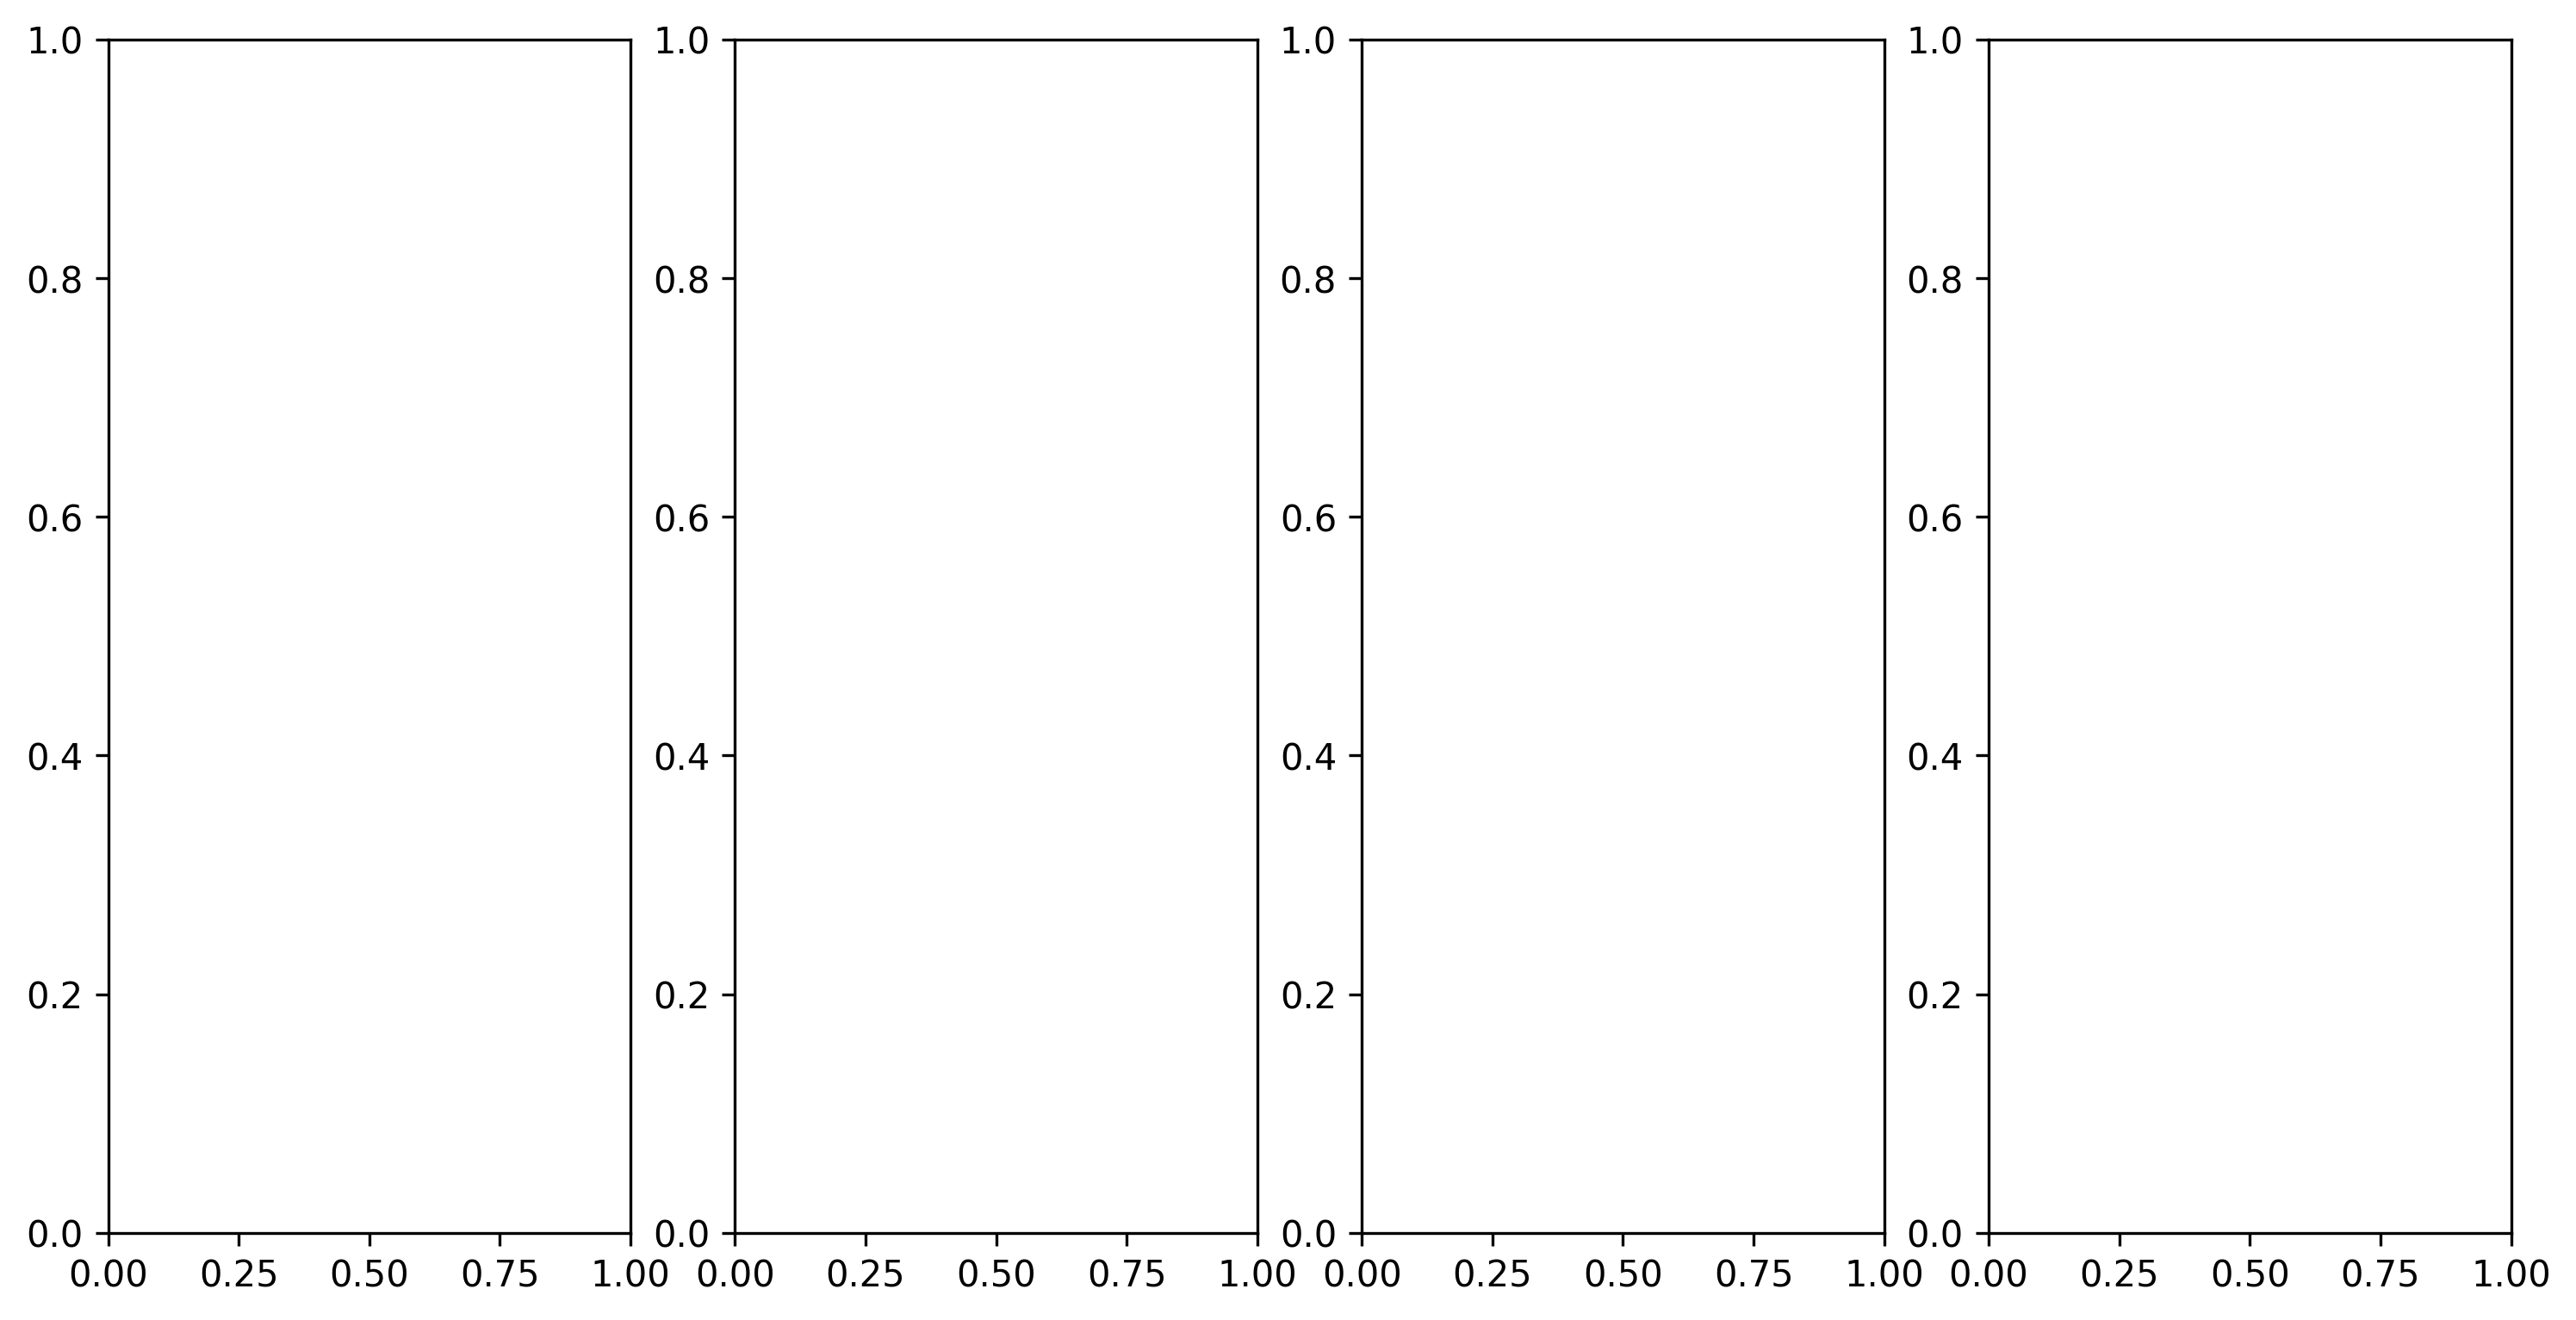

In [24]:
# Show a random sample of predictions
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

pred_threshold = 0.7

for i in range( n_samples ):
    test_set_index = int( np.random.rand() * len( testIndices ) )
    dataset_index = testIndices[test_set_index]
    img, target = cd.__getitem__( dataset_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )
    
    # Apply prediction confidence mask
    mask = predictions[test_set_index]['scores'] > 0.7
    
    img = plot_ellipses( img, target['boxes'], target['ellipse_matrices'] )
    img = plot_ellipses( img, predictions[test_set_index]['boxes'][mask], predictions[test_set_index]['ellipse_matrices'][mask], color = ( 0, 1, 0 ) )

    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tensor(0.6159)


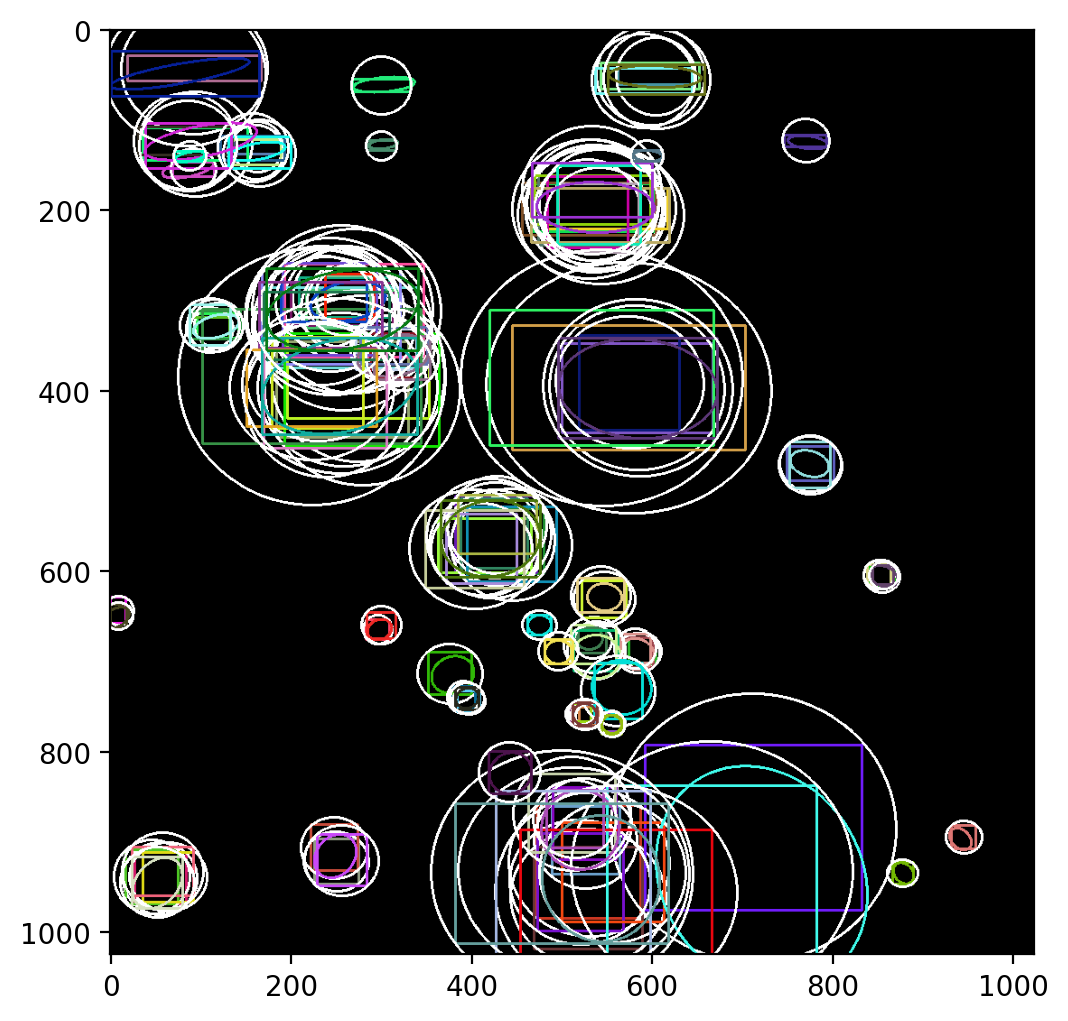

tensor(0.5427)


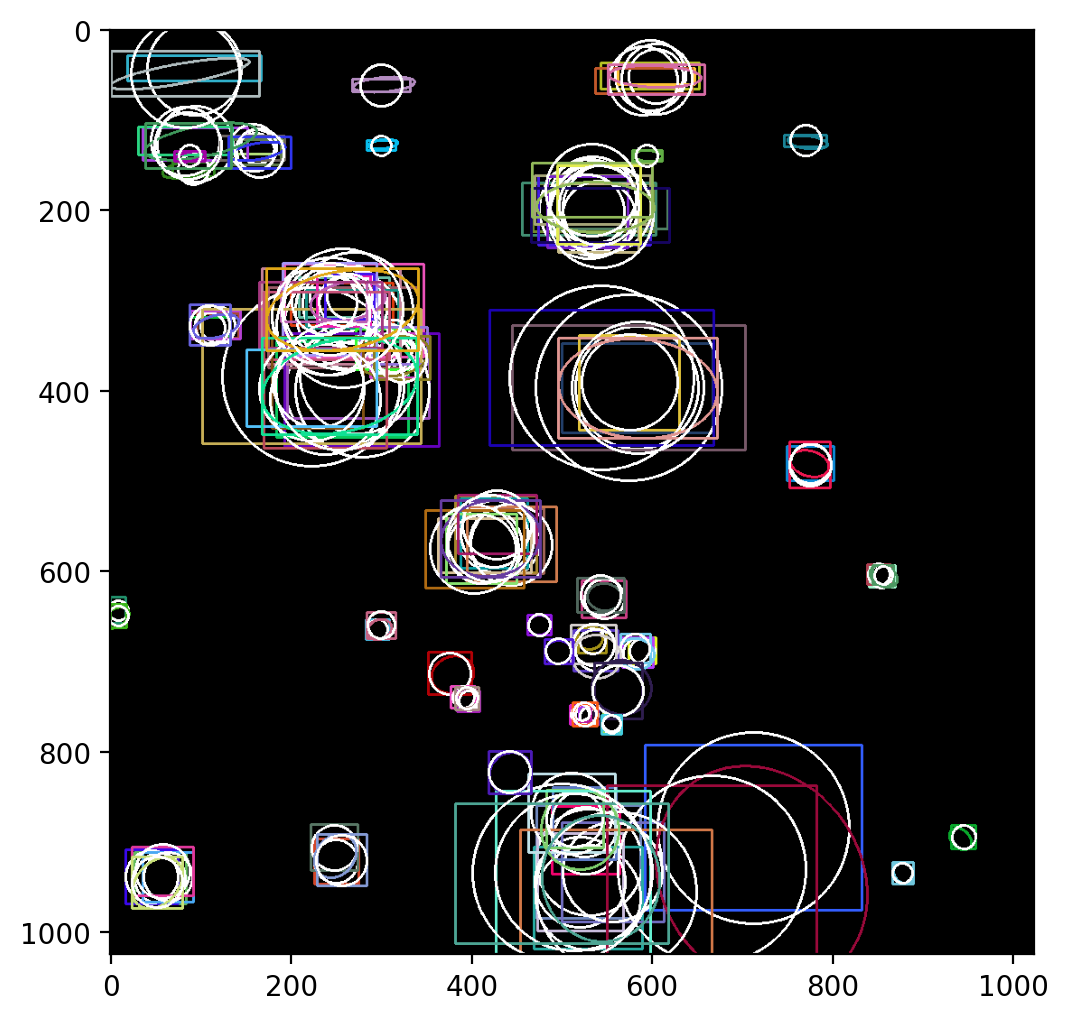

KeyError: 0

In [64]:
model.train()
device = torch.device( 'cpu' )
model.to( device )

img, target = cd.__getitem__( 2000 )
out = model( img.unsqueeze( 0 ).to( device ), [ target ] )[0]

img = img.numpy()[0]
img = np.stack( ( img, img, img ), axis = 2 )

# Apply prediction confidence mask
mask = out['scores'] > 0.0

img = plot_ellipses( img, target['boxes'], target['ellipse_matrices'] )

for bbox, ellipse in zip( out['boxes'][mask], out['ellipse_sparse'][mask] ):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )
    
    cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            color,
            2,
        )
    
    cv2.ellipse(
        img,
        ( int( ellipse[0].item() ), int( ellipse[1].item() ) ),
        ( int( ellipse[2].item() / 1.4 ), int( ellipse[3].item() / 1.4 ) ),
        ellipse[4].item() * math.pi / 180,
        0, # Start Angle for drawing
        360, # End Angle for drawing
        color,
        2,
    )

    print( ellipse[0:2], ( bbox[0] + bbox[2] ) / 2, ( bbox[1] + bbox[3] ) / 2 )

    # print( 
    #     ellipse[0].item() - ( ( bbox[0].item() + bbox[2].item() ) / 2 ),
    #     ellipse[1].item() - ( ( bbox[1].item() + bbox[3].item() ) / 2 )
    # )

plt.imshow( img )
plt.show()

In [55]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 200

False


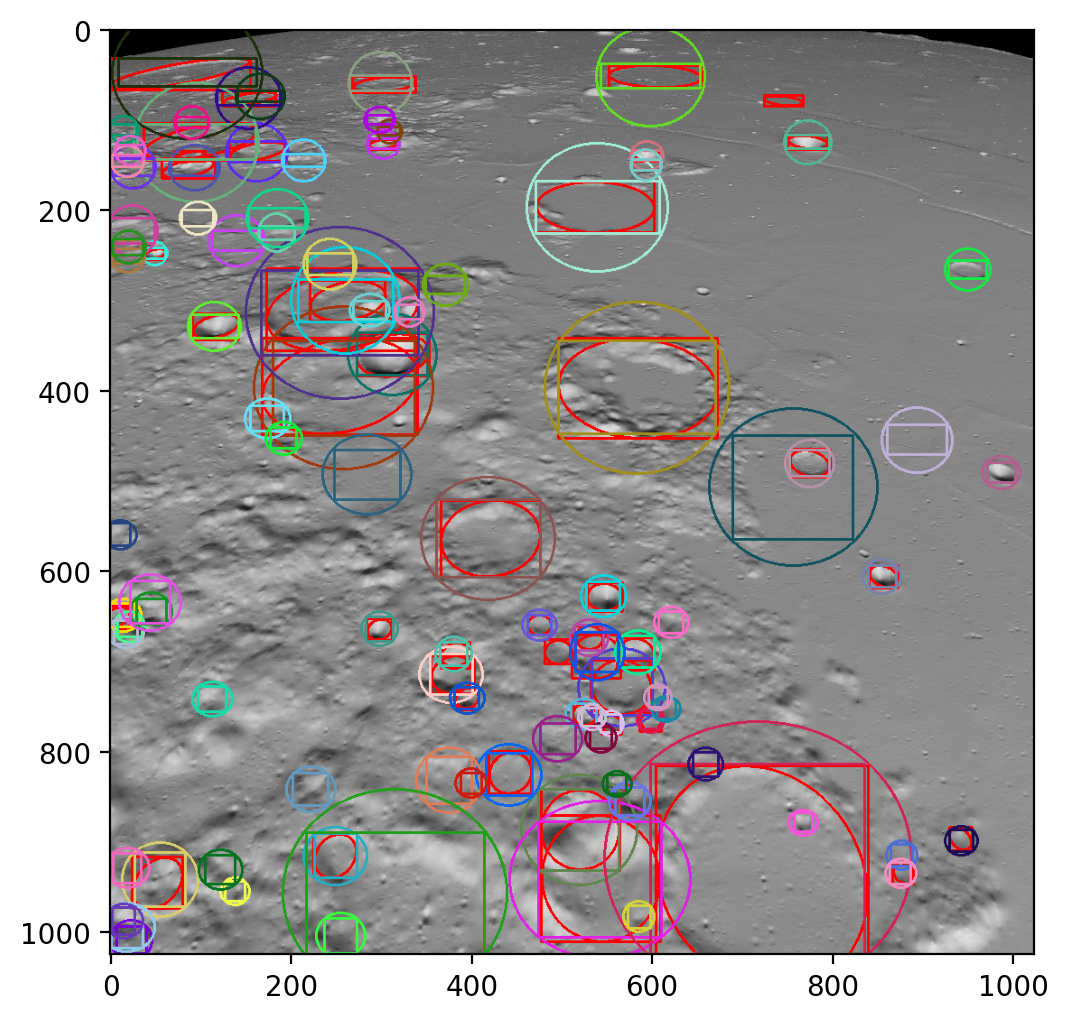

In [65]:
device = torch.device( 'cpu' )
model.to( device )
model.eval()

print( model.training )

img, target = cd.__getitem__( 2000 )
out = model( img.unsqueeze( 0 ).to( device ), [ target ] )[0]

img = img.numpy()[0]
img = np.stack( ( img, img, img ), axis = 2 )

# Apply prediction confidence mask
mask = out['scores'] > 0.0

img = plot_ellipses( img, target['boxes'], target['ellipse_matrices'] )

for bbox, ellipse in zip( out['boxes'][mask], out['ellipse_sparse'][mask] ):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )
    
    cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            color,
            2,
        )
    
    cv2.ellipse(
        img,
        ( int( ellipse[0].item() ), int( ellipse[1].item() ) ),
        ( int( ellipse[2].item() ), int( ellipse[3].item() ) ),
        ellipse[4].item() * math.pi / 180,
        0, # Start Angle for drawing
        360, # End Angle for drawing
        color,
        2,
    )

plt.imshow( img )
plt.show()